# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import math
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
535,0,29.0,54000.0,2,0
1199,0,33.0,40300.0,2,0
3872,0,39.0,40700.0,0,0
188,0,29.0,37400.0,3,0
2867,1,32.0,48900.0,0,0
3619,1,20.0,57700.0,0,0
3758,0,23.0,24100.0,0,0
2786,0,26.0,40500.0,1,0
3214,0,27.0,42900.0,3,0
2560,1,33.0,42000.0,3,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical
# write your conversion here if you choose:

df['age'] = df['age'].astype('int')

In [7]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

In [9]:
display(df.describe())
print()
print('Value Counts Insurance Benefits:')
df['insurance_benefits'].value_counts()


,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000



Value Counts Insurance Benefits:


0    4436
1     423
2     115
3      18
4       7
5       1
Name: insurance_benefits, dtype: int64

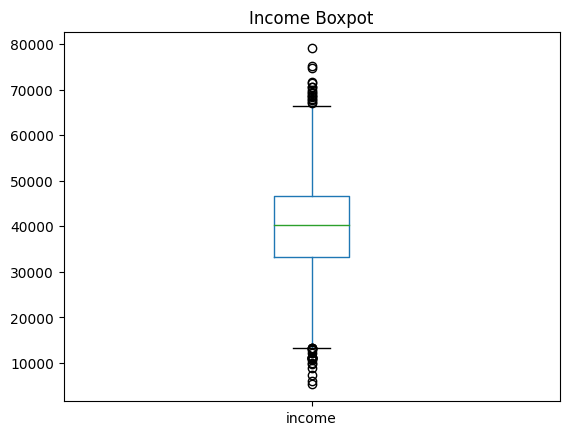

In [10]:
df['income'].plot(
kind='box',
title='Income Boxpot')
plt.show()

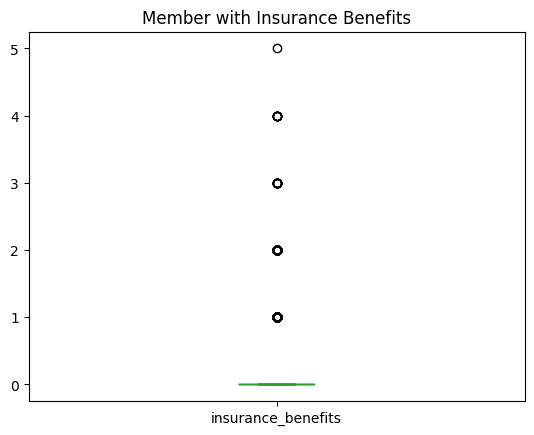

In [11]:
df['insurance_benefits'].plot(
kind='box',
title='Member with Insurance Benefits')
plt.show()

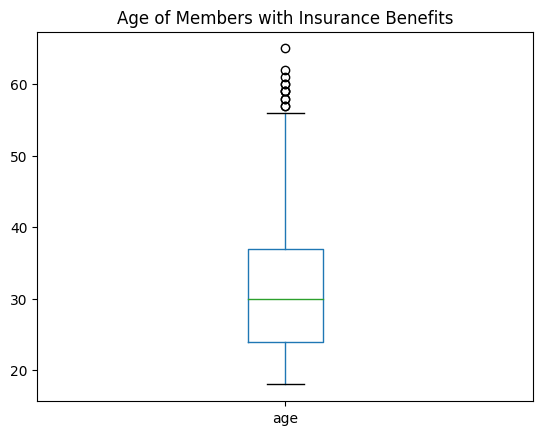

In [12]:
df['age'].plot(
kind='box',
title='Age of Members with Insurance Benefits')
plt.show()

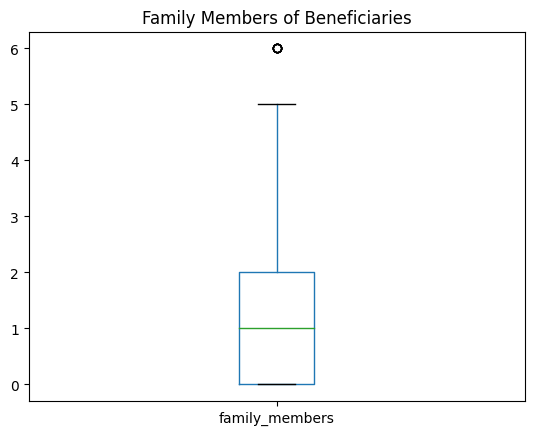

In [13]:
df['family_members'].plot(
kind='box',
title='Family Members of Beneficiaries')
plt.show()

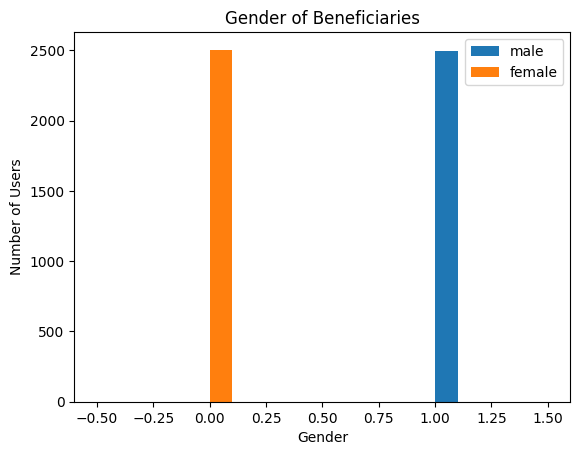

In [14]:
df['gender'][df['gender'] == 1].plot(
kind='hist',
label="male",
legend="true")
df['gender'][df['gender'] == 0].plot(
kind='hist',
label="female",
legend="true",
title='Gender of Beneficiaries')
plt.ylabel('Number of Users')
plt.xlabel("Gender")
plt.show()

### Missing Values

In [15]:
df.isna().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

By looking at the dataframes descriptive statistics, and creating each column into a plot, you can see that the columns: Insurance Benefits, Age, and Income, all have outstanding outliers, also known as extreme values. The outstanding extreme values would be in the Insurance Benefits column with the majority of the of the users not having recieved benefits, with a total of 4436.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

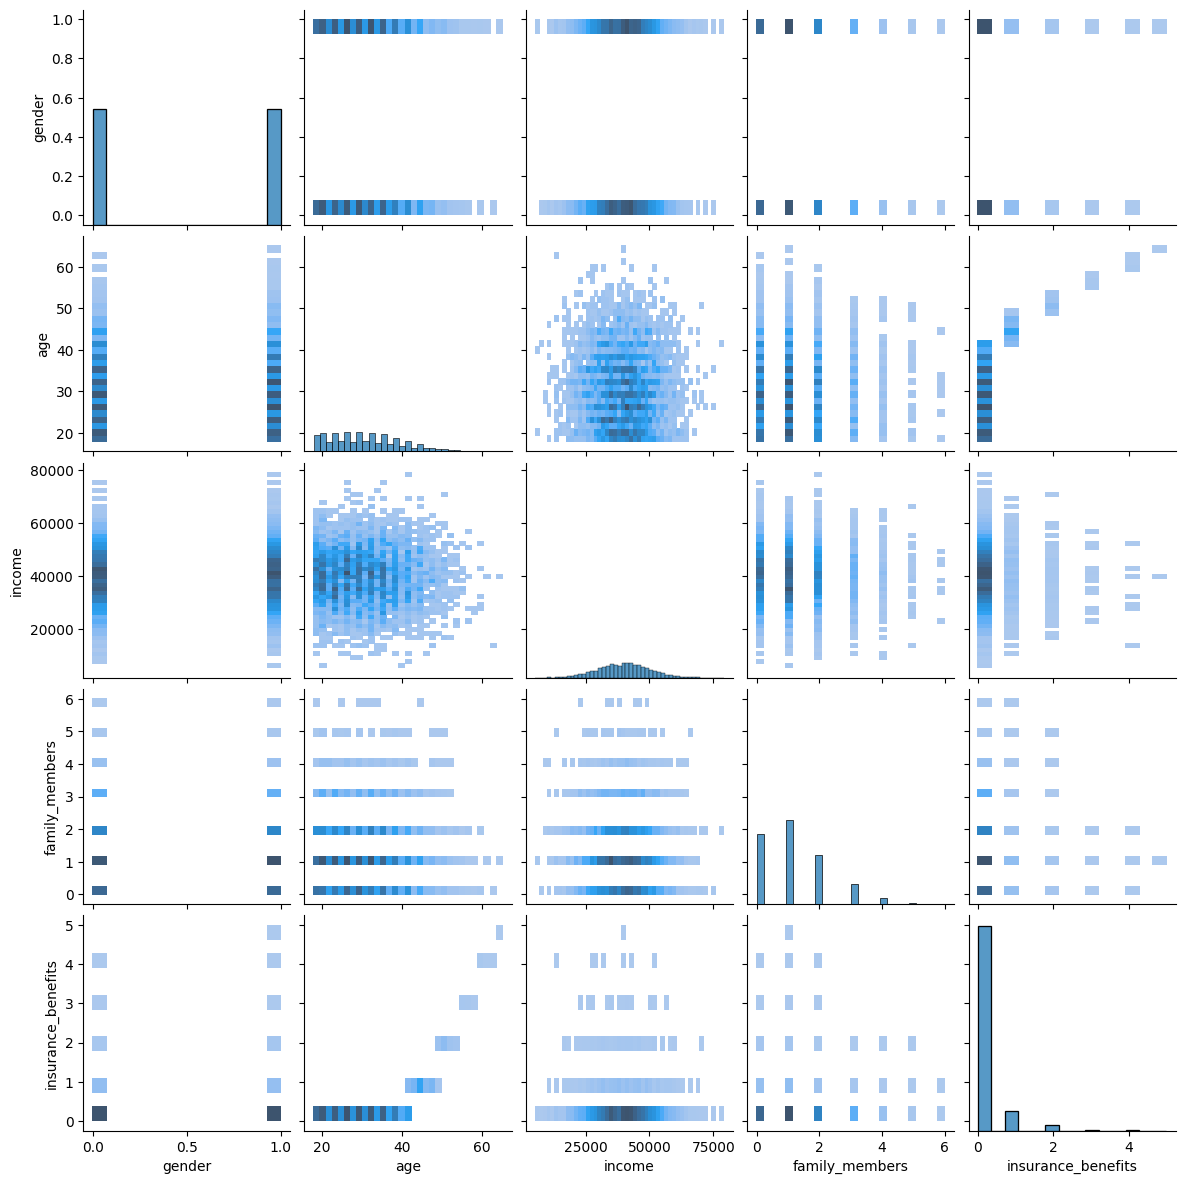

In [16]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [17]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [18]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors
    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [19]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [20]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3573,1.0,0.461538,0.453165,0.166667,0
1511,0.0,0.600000,0.563291,0.500000,0
3678,0.0,0.323077,0.560759,0.333333,0
2287,1.0,0.615385,0.407595,0.500000,0
3067,0.0,0.307692,0.525316,0.000000,0


### Euclidean Distance

#### Not Scaled

In [21]:
n = 10  # Index of the object for which you want neighbors
k = 5  # Number of nearest neighbors to retrieve
metric = 'euclidean'  # Choose a distance metric (e.g., 'euclidean', 'manhattan')

knn_euclidean = get_knn(df, n, k, metric)

knn_euclidean

,gender,age,income,family_members,insurance_benefits,distance
10,1,25,36600.0,1,0,0.000000
4039,1,25,36600.0,2,0,1.000000
2037,1,26,36600.0,0,0,1.414214
3247,1,26,36600.0,2,0,1.414214
1508,0,26,36600.0,0,0,1.732051


#### Scaled

In [22]:
n = 10 
k = 5  
metric = 'euclidean' 

knn_scaled_euclidean = get_knn(df_scaled, n, k, metric)

knn_scaled_euclidean

,gender,age,income,family_members,insurance_benefits,distance
10,1.0,0.384615,0.463291,0.166667,0,0.000000
4377,1.0,0.384615,0.473418,0.166667,0,0.010127
1389,1.0,0.369231,0.464557,0.166667,0,0.015437
760,1.0,0.369231,0.462025,0.166667,0,0.015437
2254,1.0,0.400000,0.455696,0.166667,0,0.017157


### Manhattan Distance

#### Not Scaled

In [23]:
n = 10 
k = 5  
metric = 'manhattan' 

knn_manhattan = get_knn(df, n, k, metric)

knn_manhattan

,gender,age,income,family_members,insurance_benefits,distance
10,1,25,36600.0,1,0,0.0
4039,1,25,36600.0,2,0,1.0
2037,1,26,36600.0,0,0,2.0
3247,1,26,36600.0,2,0,2.0
1508,0,26,36600.0,0,0,3.0


#### Scaled

In [24]:
n = 10 
k = 5  
metric = 'manhattan' 

knn_scaled_manhattan = get_knn(df_scaled, n, k, metric)

knn_scaled_manhattan

,gender,age,income,family_members,insurance_benefits,distance
10,1.0,0.384615,0.463291,0.166667,0,0.000000
4377,1.0,0.384615,0.473418,0.166667,0,0.010127
1389,1.0,0.369231,0.464557,0.166667,0,0.016650
760,1.0,0.369231,0.462025,0.166667,0,0.016650
2254,1.0,0.400000,0.455696,0.166667,0,0.022980


Now, let's get similar records for a given one for every combination

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, it does affect the KNN algorithm. It increases the distances between the K-nearest neighbors

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The results using the Manhattan distance are more similar to each other compared to the Euclidean metric.

In [25]:
print(knn_manhattan['distance'])
print()
print('*******************************')
print(knn_scaled_manhattan['distance'])

10      0.0
4039    1.0
2037    2.0
3247    2.0
1508    3.0
Name: distance, dtype: float64

*******************************
10      0.000000
4377    0.010127
1389    0.016650
760     0.016650
2254    0.022980
Name: distance, dtype: float64


# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [26]:
def eval_classifier(y_true, y_pred):
    """
    Function to evaluate the model performance
    """
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print(cm)

In [27]:
# generating output of a random model
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [28]:
# calculate the target
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype('int')
df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits'] > 0).astype('int')

## Original Data

In [29]:
features_original = df.drop(['insurance_benefits', 'insurance_benefits_received'], axis=1)
target_original = df['insurance_benefits_received']

X_train, X_valid, y_train, y_valid = train_test_split(features_original, target_original, test_size = .3)

def neighbors_original(n):
    knn_original = KNeighborsClassifier(n_neighbors = n)
    knn_original.fit(X_train, y_train)
    y_pred_original = knn_original.predict(X_valid)

    return eval_classifier(y_valid, y_pred_original)

In [30]:
for x in range(1, 11):
    print(f"n_neighbor: {x}")
    neighbors_original(x)
    print()

n_neighbor: 1
F1: 0.64
Confusion Matrix
[[1312   30]
 [  69   89]]

n_neighbor: 2
F1: 0.36
Confusion Matrix
[[1334    8]
 [ 122   36]]

n_neighbor: 3
F1: 0.40
Confusion Matrix
[[1314   28]
 [ 111   47]]

n_neighbor: 4
F1: 0.17
Confusion Matrix
[[1335    7]
 [ 143   15]]

n_neighbor: 5
F1: 0.19
Confusion Matrix
[[1328   14]
 [ 140   18]]

n_neighbor: 6
F1: 0.06
Confusion Matrix
[[1342    0]
 [ 153    5]]

n_neighbor: 7
F1: 0.07
Confusion Matrix
[[1340    2]
 [ 152    6]]

n_neighbor: 8
F1: 0.02
Confusion Matrix
[[1342    0]
 [ 156    2]]

n_neighbor: 9
F1: 0.04
Confusion Matrix
[[1341    1]
 [ 155    3]]

n_neighbor: 10
F1: 0.02
Confusion Matrix
[[1341    1]
 [ 156    2]]



## Scaled DataFrame

In [31]:
features_scaled = df_scaled.drop(['insurance_benefits', 'insurance_benefits_received'], axis=1)
target_scaled = df_scaled['insurance_benefits_received']

X_train_scaled, X_valid_scaled, y_train_scaled, y_valid_scaled = train_test_split(features_scaled, target_scaled, test_size = .3)

def scaled_neighbors(n):
    knn_scaled = KNeighborsClassifier(n_neighbors = n)
    knn_scaled.fit(X_train_scaled, y_train_scaled)
    y_pred_scaled = knn_scaled.predict(X_valid_scaled)

    return eval_classifier(y_valid_scaled, y_pred_scaled)

for x in range(1, 11):
    print(f"n_neighbor: {x}")
    scaled_neighbors(x)
    print()

n_neighbor: 1
F1: 0.93
Confusion Matrix
[[1329   10]
 [  13  148]]

n_neighbor: 2
F1: 0.93
Confusion Matrix
[[1335    4]
 [  18  143]]

n_neighbor: 3
F1: 0.92
Confusion Matrix
[[1328   11]
 [  14  147]]

n_neighbor: 4
F1: 0.91
Confusion Matrix
[[1335    4]
 [  24  137]]

n_neighbor: 5
F1: 0.90
Confusion Matrix
[[1326   13]
 [  20  141]]

n_neighbor: 6
F1: 0.89
Confusion Matrix
[[1334    5]
 [  27  134]]

n_neighbor: 7
F1: 0.91
Confusion Matrix
[[1331    8]
 [  19  142]]

n_neighbor: 8
F1: 0.92
Confusion Matrix
[[1338    1]
 [  24  137]]

n_neighbor: 9
F1: 0.92
Confusion Matrix
[[1333    6]
 [  19  142]]

n_neighbor: 10
F1: 0.90
Confusion Matrix
[[1335    4]
 [  26  135]]



## Dummy Model

In [32]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
  print(f'The probability: {P:.2f}')
  y_pred_rnd = np.random.choice([0, 1], size=len(df), p=[1-P, P])

  eval_classifier(df['insurance_benefits_received'], y_pred_rnd)

  print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[4436    0]
 [ 564    0]]

The probability: 0.11
F1: 0.10
Confusion Matrix
[[3956  480]
 [ 511   53]]

The probability: 0.50
F1: 0.18
Confusion Matrix
[[2194 2242]
 [ 289  275]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[   0 4436]
 [   0  564]]



After using  the original data, scaling and using a dummy model. The model with the best F1 score would be the model using the scaled model with a highest F1 score of .96, being the first KNearest-Neighbor.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [33]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ (X2.T @ y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [34]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [35]:
features = df.drop(['insurance_benefits'], axis=1)
target = df['insurance_benefits']

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=.3, random_state=10)
my_linear = MyLinearRegression()
my_linear.fit(X_train, y_train)
prediction_my_linear = my_linear.predict(X_valid)
eval_regressor(y_valid, prediction_my_linear)

RMSE: 0.21
R2: 0.88


In [37]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.58116956e-01  3.63957606e-02  6.12909834e-03 -1.74088968e-07
 -1.04321947e-02]
RMSE: 0.35
R2: 0.63


# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [38]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [39]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [40]:
rng = np.random.default_rng(seed=10)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [41]:
np.linalg.inv(P)

array([[ 1.82834634, -3.18840339, -2.76613531,  3.58506886],
       [ 0.06638967, -2.24593401, -0.3307102 ,  2.13452774],
       [-0.84079976,  4.23804865,  3.47410963, -4.94606624],
       [-0.43631409,  0.02390777, -1.10526146,  1.51999941]])

Checking the matrix $P$ is invertible

In [42]:
try:
  inverse = np.linalg.inv(P)
  print("P is invertible. Its inverse:")
  print(inverse)
except np.linalg.LinAlgError:
  print("P is not invertible (singular matrix).")

P is invertible. Its inverse:
[[ 1.82834634 -3.18840339 -2.76613531  3.58506886]
 [ 0.06638967 -2.24593401 -0.3307102   2.13452774]
 [-0.84079976  4.23804865  3.47410963 -4.94606624]
 [-0.43631409  0.02390777 -1.10526146  1.51999941]]


Can you guess the customers' ages or income after the transformation?

No, it is not possible to guess the customers age or income after the transformation.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [43]:
# Transform the original data
X_prime = np.dot(X, P)

# Compute the inverse of P
P_inverse = np.linalg.inv(P)

# Recover the original data
X_reversed = np.dot(X_prime, P_inverse)

In [44]:
X_reversed

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 2.06275338e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-4.83571442e-13,  2.90000000e+01,  2.10000000e+04,
        -1.28807101e-12],
       ...,
       [ 2.10827573e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

In [45]:
X_prime

array([[21127.80302282, 47470.06345873, 40966.41820118, 16811.07387588],
       [16193.50667429, 36370.19373488, 31395.17322463, 12891.83570771],
       [ 8950.56027938, 20099.38774104, 17351.97309199,  7126.93224591],
       ...,
       [14436.16262545, 32444.01651288, 27994.22046391, 11484.20092421],
       [13928.10920006, 31296.93813162, 27006.85459803, 11081.10876529],
       [17291.55558616, 38855.96247279, 33529.46456948, 13756.19334322]])

In [46]:
P_inverse

array([[ 1.82834634, -3.18840339, -2.76613531,  3.58506886],
       [ 0.06638967, -2.24593401, -0.3307102 ,  2.13452774],
       [-0.84079976,  4.23804865,  3.47410963, -4.94606624],
       [-0.43631409,  0.02390777, -1.10526146,  1.51999941]])

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

In [47]:
if np.allclose(X, X_reversed):
    print("\nThe recovered data closely matches the original data.")
else:
    print("\nThere are some differences due to numerical precision.")


The recovered data closely matches the original data.


After further investigation, the discrepancy is often due to numerical precision limitations which can occur during matrix inversion and multiplication operations, especially dialing with floating-point arithmetic.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

**Analytical proof**

1. Original Linear Regression Solution  
Start with the known linear regression solution:  

$w = (X^T X)^{-1} X^Ty$

2. Substitute the Obfuscated Data:

Substitute $( X' = XP )$:

$wp = (X'^T X')^{-1} X'^Ty$

where $( X' = XP )$ 

3. Rewrite $( X' )$ in terms of $( X )$ and $( P )$:

$( X' = XP )$ and thus $( X'^T = (XP)^T = P^T X^T )$ 

4. Simplify the Expression  
Substitute $( X' )$and $( X'^T )$ into the equation for $( w_p )$:  
$w_p = (P^T X^T XP)^{-1} (P^T X^T)y$ 

5. Use associativity to regroup terms  
$w_p = (P^T (X^T X) P)^{-1} P^T X^Ty$

6. Simplify $( (P^T (X^T X) P)^{-1} )$   

$(P^T (X^T X) P)^{-1} = P^{-1} (X^T X)^{-1} (P^T)^{-1} = P^{-1} (X^T X)^{-1} P^{-T}$

7. Substitute this back into the equation for $( w_p )$:  
$w_p = P^{-1} (X^T X)^{-1} P^{-T} P^T X^T y$  

8. Simplify by removing $( P^{-T} P^T )$ (which is the identity matrix since $( P^{-T} = (P^{-1})^T ))$:  
$w_p = P^{-1} (X^T X)^{-1} X^T y$

9. Recognize that this is just $( P^{-1} w )$:  
$w_p = P^{-1} w$  

Examine the predicted Value:  

10. Look at the prediction formula:  
$a = X w$

11. Substitute with the obfuscated parameters:  
$a' = X P w_p$ 

12. Substitute $( w_p )$ from the earlier step:  
$w_p = P^{-1} w$

13. Thus:  
$a' = X P (P^{-1} w)$

14. Simplify:  
$a' = X (P P^{-1}) w$  

15. Recognize that $( P P^{-1} )$ is the identity matrix $( I )$:  
$a' = X I w$  

16. Since $( X I = X )$:  
$a' = X w$  

17. Thus, we have shown that:  
$a' = a$

Conclusion:  
Proof now correctly shows that $( w_p = P^{-1} w )$ and that $( a' = a )$, proving that obfuscation has no effect on the predictions.


## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Use $XP$ as the new feature matrix

In [48]:
features_obf = df.drop(['insurance_benefits', 'insurance_benefits_received'], axis=1)
target_obf = df['insurance_benefits']

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(features_obf, target_obf, test_size=.3)

In [50]:
squared_matrix = np.random.randn(4, 4)
inverted_matrix = np.linalg.inv(squared_matrix)

In [51]:
model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_valid)
mse = mean_squared_error(y_valid, prediction)
rmse = np.sqrt(mse)
print(f"MSE on original data: {mse:.4f}")
print(f"RSME on original data:{rmse:.4f}")

MSE on original data: 0.1340
RSME on original data:0.3660


In [52]:
# Generate random invertible transformation matrix
n_features = X.shape[1]
P = squared_matrix

# Apply transformation to training data
X_train_P = X_train @ P

# Train linear regression model with transformed data
model_obf = LinearRegression()
model_obf.fit(X_train_P, y_train)

# Predict on transformed testing data
y_hat_P = model_obf.predict(X_valid @ P)

mse_P = mean_squared_error(y_valid, y_hat_P)
rsme_P = np.sqrt(mse_P)
print(f"MSE on transformed data: {mse_P:.4f}")
print(f"RMSE on transformed data: {rsme_P:.4f}")

MSE on transformed data: 0.1340
RMSE on transformed data: 0.3660


# Conclusions

In the first task of this analysis, after creating a function to retrieve the KNearest Neighbors, we took the original dataframe and a scaled dataframe to see if the data not being scaled affect the KNN algorithm and we determined that it does affect the KNN algorithm. It increases the distances between the K-nearest neighbors. After scaling the results, we saw that the results using the Manhattan distance are more similar to each other compared to the Euclidean metric.  

In the second part of this project, using the F1 metric, we created a few models to determine how likely a customer to receive Insurance benefits. After creating models using the original data, scaled data and a dummy model with linear regression, you can see that the model with the highest F1 score is the model with the scaled data. With The highest F1 score of .96 with the first KNearest Neighbor.

In the next portion of this analysis, we created a Linear Regression Model, using the Root mean squared error and the R2 score as metrics to evaluate the model, resulting a RMSE: .21 and a R2:.90.

On the Final part of this project, we obfuscated the data and created a Linear Regression model to test the data on obfuscated data and unobfuscated data, while using the RMSE metric to evaluate out model, you can see that the results are the same between obfuscated data and unobfuscated data. Having no negative effect obfuscating the data.



# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>

